In [1]:
import requests
import pandas as pd
from datetime import datetime

# API URL
url = "http://127.0.0.1:9090/bom/search/field/Date?gte=2023-06-01&lte=2024-05-01"

# Try to fetch data from API
try:
    response = requests.get(url)
    data = response.json()

    # Check if the request was successful
    if response.status_code == 200:
        # Extract 'data' field
        weather_data = data['data']

        # Load data into a DataFrame
        df = pd.DataFrame(weather_data)
        
        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Set 'Date' as the index
        df.set_index('Date', inplace=True)
        
        # Convert columns to appropriate types
        df['Rainfall (mm)'] = pd.to_numeric(df['Rainfall (mm)'])
        df['Speed of maximum wind gust (km/h)'] = pd.to_numeric(df['Speed of maximum wind gust (km/h)'])
        df['Sunshine (hours)'] = pd.to_numeric(df['Sunshine (hours)'])
        
        # Resample by month and calculate mean
        monthly_means = df.resample('M').mean()

        # Format the index to show only month names
        monthly_means.index = monthly_means.index.strftime('%B')

        # Store the monthly averages in a variable for later use
        monthly_averages = monthly_means

        # Print monthly mean values
        print(monthly_averages)
    else:
        print(f"Failed to fetch data: {response.status_code} - {data.get('message', '')}")
except requests.exceptions.RequestException as e:
    print(f"Error connecting to the API: {e}")


           Rainfall (mm)  Speed of maximum wind gust (km/h)  Sunshine (hours)
Date                                                                         
June            1.760000                          35.900000          3.800000
July            0.664516                          34.774194          4.958065
August          0.722581                          32.387097          5.003226
September       0.360000                          37.233333          7.576667
October         2.451613                          38.677419          6.477419
November        1.413333                          35.266667          6.413333
December        2.303226                          36.548387          6.687097
January         3.509677                          36.000000          7.509677
February        0.213793                          36.620690          9.120690
March           0.090323                          33.580645          8.525806
April           4.126667                          28.033333     

In [2]:
sentiment_results = {}

base_url = "http://127.0.0.1:9090/twitter/search/sentiment/average/field/created_at"

dates = pd.date_range(start="2021-06-01", end="2022-04-01", freq='MS')

for date in dates:
    start_date = date.strftime('%Y-%m-%d')
    end_date = (date + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    url = f"{base_url}?gte={start_date}&lte={end_date}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if response.status_code == 200 and data['status'] == 'success':
            sentiment_results[date.strftime('%B')] = data['data']
        else:
            sentiment_results[date.strftime('%B')] = 'Data Fetch Failed'
    
    except requests.exceptions.RequestException as e:
        sentiment_results[date.strftime('%B')] = 'API Request Failed'

sentiment_df = pd.DataFrame(list(sentiment_results.items()), columns=['Month', 'Average Sentiment'])

print(sentiment_df)


        Month  Average Sentiment
0        June           0.057217
1        July           0.053154
2      August           0.050481
3   September           0.049900
4     October           0.055391
5    November           0.052693
6    December           0.061981
7     January           0.059786
8    February           0.063304
9       March           0.063305
10      April           0.068479


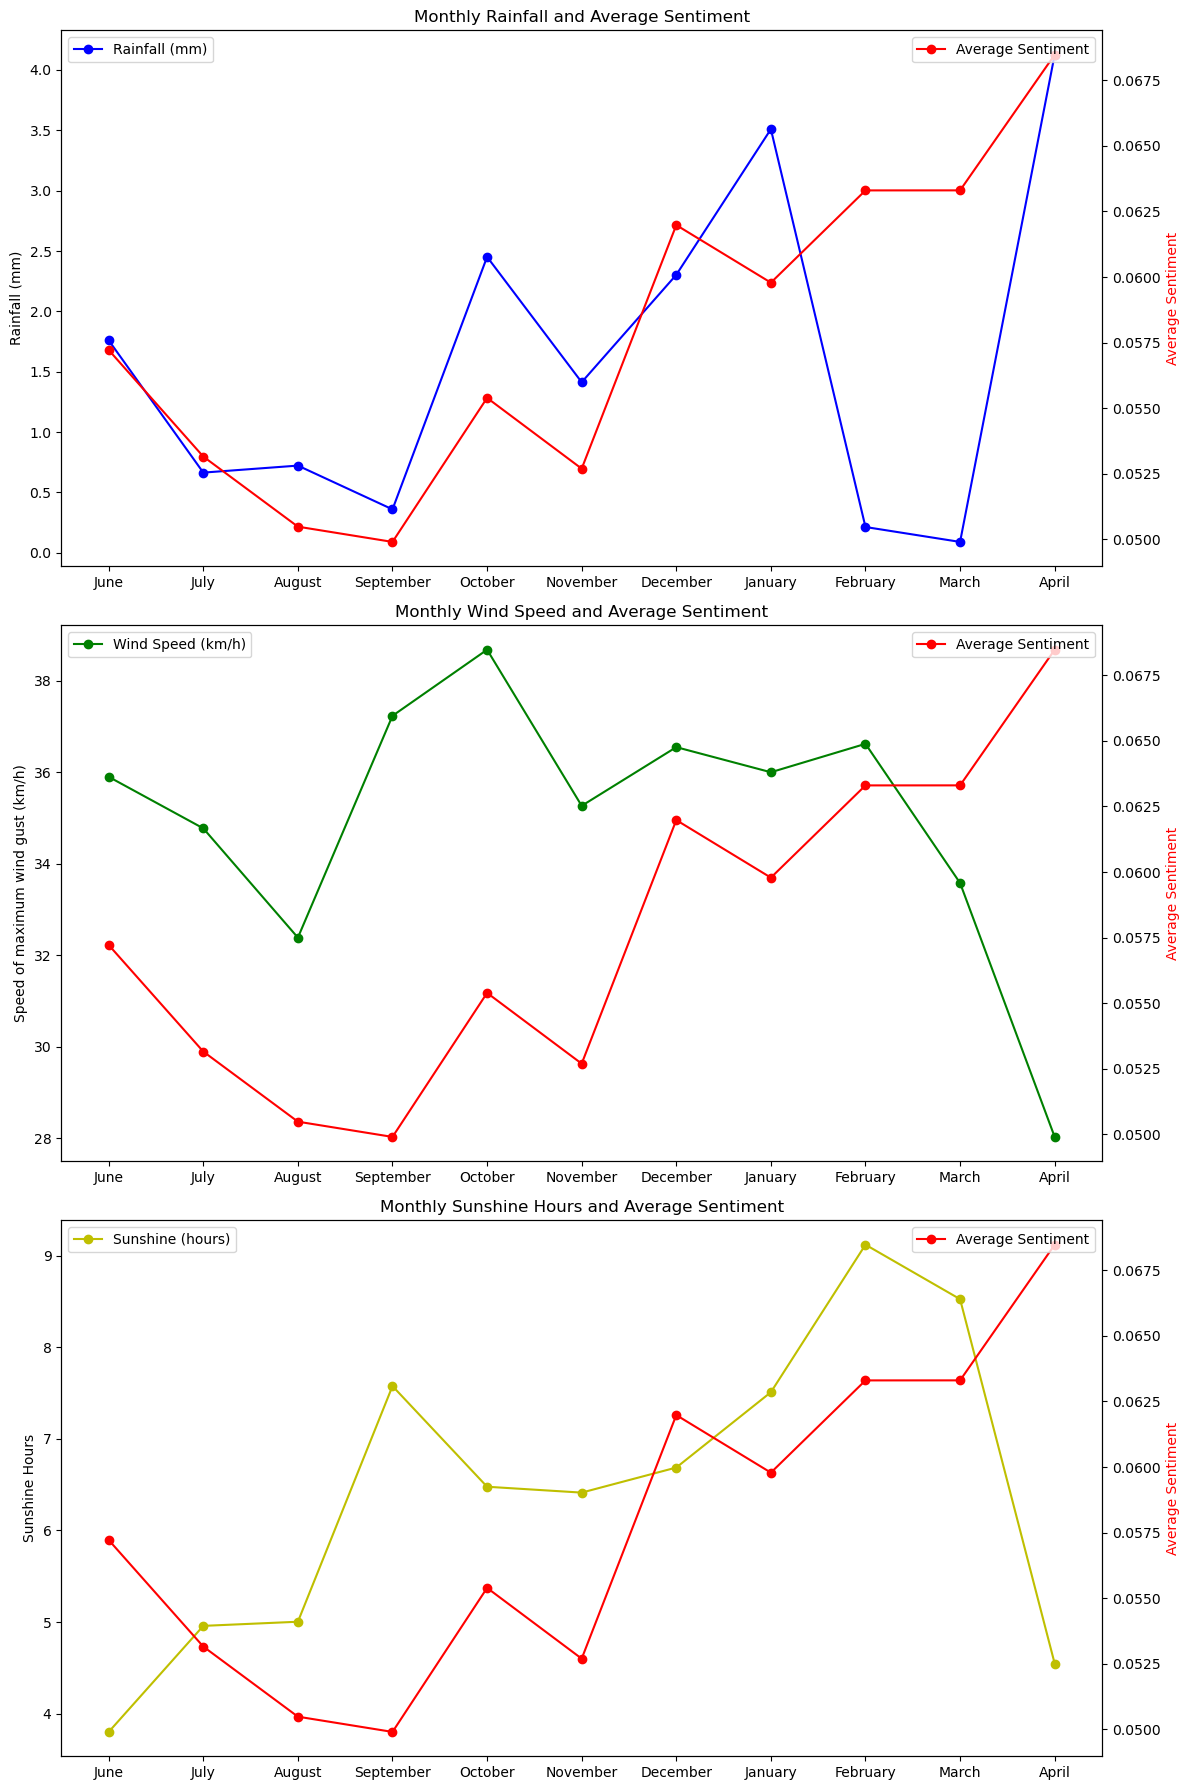

In [3]:
import matplotlib.pyplot as plt
months = monthly_averages.index.tolist()

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

ax1 = axs[0]
ax1_twin = ax1.twinx()
ax1.plot(months, monthly_averages['Rainfall (mm)'], 'b-o', label='Rainfall (mm)')
ax1_twin.plot(sentiment_df['Month'], sentiment_df['Average Sentiment'], 'r-o', label='Average Sentiment')
ax1.set_title('Monthly Rainfall and Average Sentiment')
ax1.set_ylabel('Rainfall (mm)')
ax1_twin.set_ylabel('Average Sentiment', color='r')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

ax2 = axs[1]
ax2_twin = ax2.twinx()
ax2.plot(months, monthly_averages['Speed of maximum wind gust (km/h)'], 'g-o', label='Wind Speed (km/h)')
ax2_twin.plot(sentiment_df['Month'], sentiment_df['Average Sentiment'], 'r-o', label='Average Sentiment')
ax2.set_title('Monthly Wind Speed and Average Sentiment')
ax2.set_ylabel('Speed of maximum wind gust (km/h)')
ax2_twin.set_ylabel('Average Sentiment', color='r')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

ax3 = axs[2]
ax3_twin = ax3.twinx()
ax3.plot(months, monthly_averages['Sunshine (hours)'], 'y-o', label='Sunshine (hours)')
ax3_twin.plot(sentiment_df['Month'], sentiment_df['Average Sentiment'], 'r-o', label='Average Sentiment')
ax3.set_title('Monthly Sunshine Hours and Average Sentiment')
ax3.set_ylabel('Sunshine Hours')
ax3_twin.set_ylabel('Average Sentiment', color='r')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()
